# Analysis of Human and LLM Entropy

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import seaborn as sns
import statsmodels.formula.api as sm
from tqdm import tqdm

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # makes figs nicer!

### Load data

In [4]:
df_gpt = pd.read_csv("data/processed/llm_appreciation.csv")
df_gpt['Sentence'] = df_gpt['sentence']
df_gpt['entropy_gpt'] = df_gpt['entropy']
df_gpt = df_gpt[['Sentence', 'best_response', 'best_response_lp', 'entropy_gpt', 'is_joke']]
df_gpt.head(5)

,Sentence,best_response,best_response_lp,entropy_gpt,is_joke
0,A committee keeps minutes and takes hours.,3,-0.615764,0.694764,True
1,A committee keeps minutes and takes votes.,1,-0.649445,0.669604,False
2,A device for finding furniture in the dark is ...,3,-0.613520,0.640976,False
3,A device for finding furniture in the dark is ...,3,-0.393362,0.704891,True
4,A good source of vitamin A is orange vegetable...,1,-0.100589,0.098394,False


In [5]:
df_human = pd.read_csv("data/processed/human_data_appreciation/JokeFunniness_data_153Subs.csv")
df_human = df_human[['ResponseJoke', 'ResponseFunny', 'Sentence']]
df_human.head(3)

,ResponseJoke,ResponseFunny,Sentence
0,0,1,A good source of vitamin A is orange vegetable...
1,0,1,A good source of vitamin A is orange vegetable...
2,0,1,A good source of vitamin A is orange vegetable...


In [6]:
df_surprisals = pd.read_csv("data/processed/results_gpt.csv")
df_surprisals = df_surprisals[df_surprisals['model']=="text-davinci-002"]
df_surprisals['Sentence'] = df_surprisals['sentence']
df_surprisals = df_surprisals[['Sentence', 'surprisal']]

### Calculate human avgs

In [7]:
df_human_avg = df_human.groupby("Sentence").mean().reset_index()
df_human_avg.head(3)

,Sentence,ResponseJoke,ResponseFunny
0,A committee keeps minutes and takes hours.,0.622222,2.066667
1,A committee keeps minutes and takes votes.,0.085714,1.171429
2,A device for finding furniture in the dark is ...,0.282051,1.358974


### Calculate human entropy

In [8]:
# Function to calculate entropy
def entropy(probs):
    return -np.sum([p * np.log2(p) for p in probs if p > 0])

In [9]:
# Calculate entropy for each sentence
entropy_per_sentence = df_human.groupby('Sentence')['ResponseFunny'].apply(
    lambda x: entropy(x.value_counts(normalize=True))
)

### Merge

In [10]:
df_human_avg['entropy_human'] = df_human_avg['Sentence'].apply(lambda x: entropy_per_sentence[x])

In [11]:
df_merged = pd.merge(df_gpt, df_human_avg)
df_merged.head(5)

,Sentence,best_response,best_response_lp,entropy_gpt,is_joke,ResponseJoke,ResponseFunny,entropy_human
0,A committee keeps minutes and takes hours.,3,-0.615764,0.694764,True,0.622222,2.066667,1.862757
1,A committee keeps minutes and takes votes.,1,-0.649445,0.669604,False,0.085714,1.171429,0.626995
2,A device for finding furniture in the dark is ...,3,-0.613520,0.640976,False,0.282051,1.358974,1.006391
3,A device for finding furniture in the dark is ...,3,-0.393362,0.704891,True,0.647059,2.323529,1.947983
4,A good source of vitamin A is orange vegetable...,1,-0.100589,0.098394,False,0.025000,1.075000,0.336397


In [12]:
df_merged = pd.merge(df_merged, df_surprisals)
df_merged.head(5)

,Sentence,best_response,best_response_lp,entropy_gpt,is_joke,ResponseJoke,ResponseFunny,entropy_human,surprisal
0,A committee keeps minutes and takes hours.,3,-0.615764,0.694764,True,0.622222,2.066667,1.862757,7.498854
1,A committee keeps minutes and takes votes.,1,-0.649445,0.669604,False,0.085714,1.171429,0.626995,2.771935
2,A device for finding furniture in the dark is ...,3,-0.613520,0.640976,False,0.282051,1.358974,1.006391,9.741494
3,A device for finding furniture in the dark is ...,3,-0.393362,0.704891,True,0.647059,2.323529,1.947983,15.305808
4,A good source of vitamin A is orange vegetable...,1,-0.100589,0.098394,False,0.025000,1.075000,0.336397,0.024038


### Analysis 1: Overall uncertainty

In [13]:
df_melted = pd.melt(df_merged[['Sentence', 'entropy_gpt', 'entropy_human', 'is_joke', 'surprisal']], id_vars = ['Sentence', 'surprisal','is_joke'],
       var_name= "Source", value_name = "Entropy")
df_melted.head(3)

,Sentence,surprisal,is_joke,Source,Entropy
0,A committee keeps minutes and takes hours.,7.498854,True,entropy_gpt,0.694764
1,A committee keeps minutes and takes votes.,2.771935,False,entropy_gpt,0.669604
2,A device for finding furniture in the dark is ...,9.741494,False,entropy_gpt,0.640976


In [14]:
df_melted[['Source', 'Entropy']].groupby("Source").describe()

Entropy                                                    \
                count      mean       std       min       25%       50%   
Source                                                                    
entropy_gpt     400.0  0.737186  0.283472  0.039843  0.638445  0.810889   
entropy_human   400.0  1.222564  0.675861 -0.000000  0.609559  1.279338   

                                   
                    75%       max  
Source                             
entropy_gpt    0.935420  1.266703  
entropy_human  1.853451  2.259846

In [15]:
mod = sm.ols(data = df_melted, formula = "Entropy ~ Source * is_joke + surprisal").fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Entropy   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     345.9
Date:                Tue, 05 Dec 2023   Prob (F-statistic):          2.41e-172
Time:                        15:16:15   Log-Likelihood:                -284.57
No. Observations:                 800   AIC:                             579.1
Df Residuals:                     795   BIC:                             602.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   0.5124      0.027     18.928      0.000       0.459       0.566
Source[T.entropy_human]                     0.1494      0.032      4.724      0.000       0.087       0.211
is_joke[T.True]                             0.0813      0.038      2.160      0.031       0.007       0.155
Source[T.entropy_human]:is_joke[T.True]     0.8400      0.050     16.799      0.000       0.742       0.938
surprisal                                   0.0280      0.003      9.418      0.000       0.022       0.034
==============================================================================
Omnibus:                        8.957   Durbin-Watson:                   1.823
Prob(Omnibus):                  0.011   Jarque-Bera (JB):               11.630
Skew:                           0.121   Prob(JB):                      0.00298
Kurtosis:                       3.539   Cond. No.                         42.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: xlabel='Source', ylabel='Entropy'>

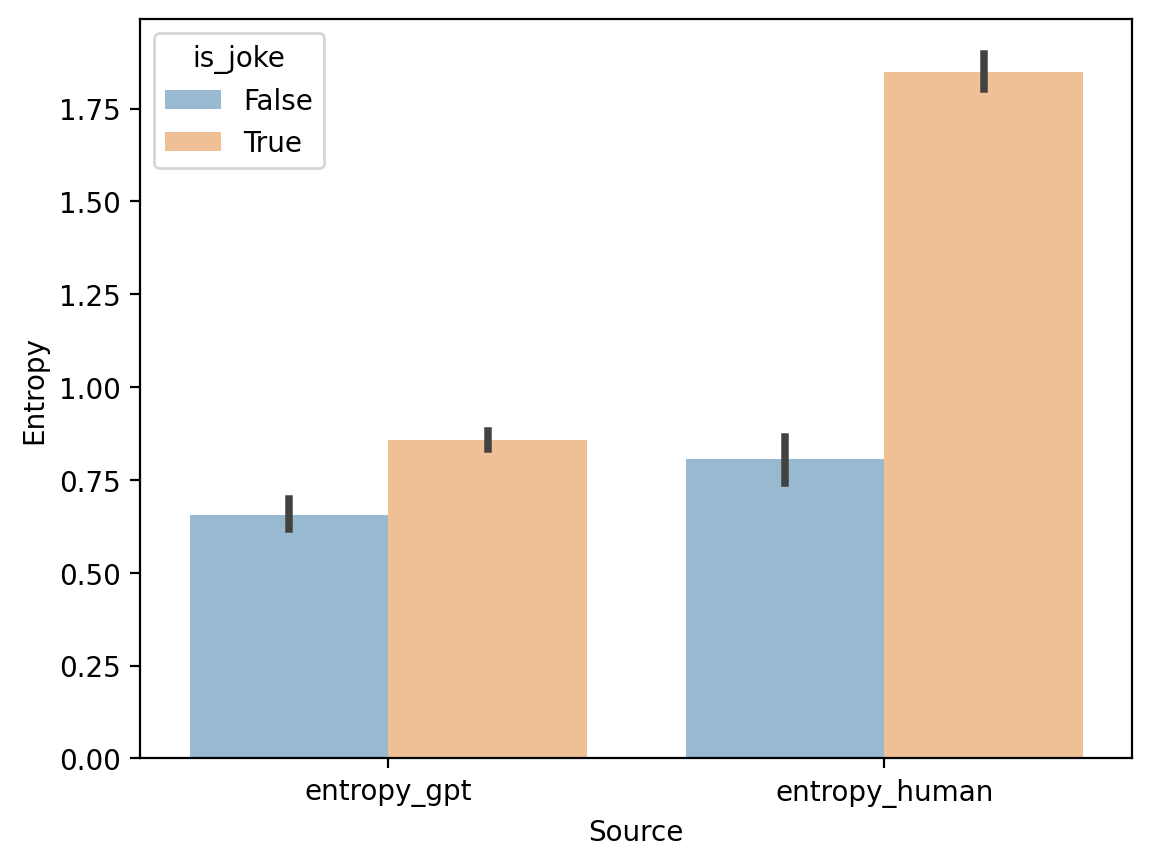

In [16]:
sns.barplot(data = df_melted, x = "Source", y = "Entropy", hue = "is_joke", alpha = .5)

### Analysis 2: Correlated uncertainty

In [17]:
mod = sm.ols(data = df_merged, formula = "entropy_human ~ entropy_gpt + surprisal + is_joke").fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          entropy_human   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     248.8
Date:                Tue, 05 Dec 2023   Prob (F-statistic):           1.04e-90
Time:                        15:16:18   Log-Likelihood:                -198.50
No. Observations:                 400   AIC:                             405.0
Df Residuals:                     396   BIC:                             421.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.3932      0.057      6.843      0.000       0.280       0.506
is_joke[T.True]     0.8158      0.047     17.322      0.000       0.723       0.908
entropy_gpt         0.3453      0.077      4.463      0.000       0.193       0.497
surprisal           0.0362      0.005      7.266      0.000       0.026       0.046
==============================================================================
Omnibus:                        5.318   Durbin-Watson:                   1.871
Prob(Omnibus):                  0.070   Jarque-Bera (JB):                5.668
Skew:                           0.181   Prob(JB):                       0.0588
Kurtosis:                       3.457   Cond. No.                         38.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


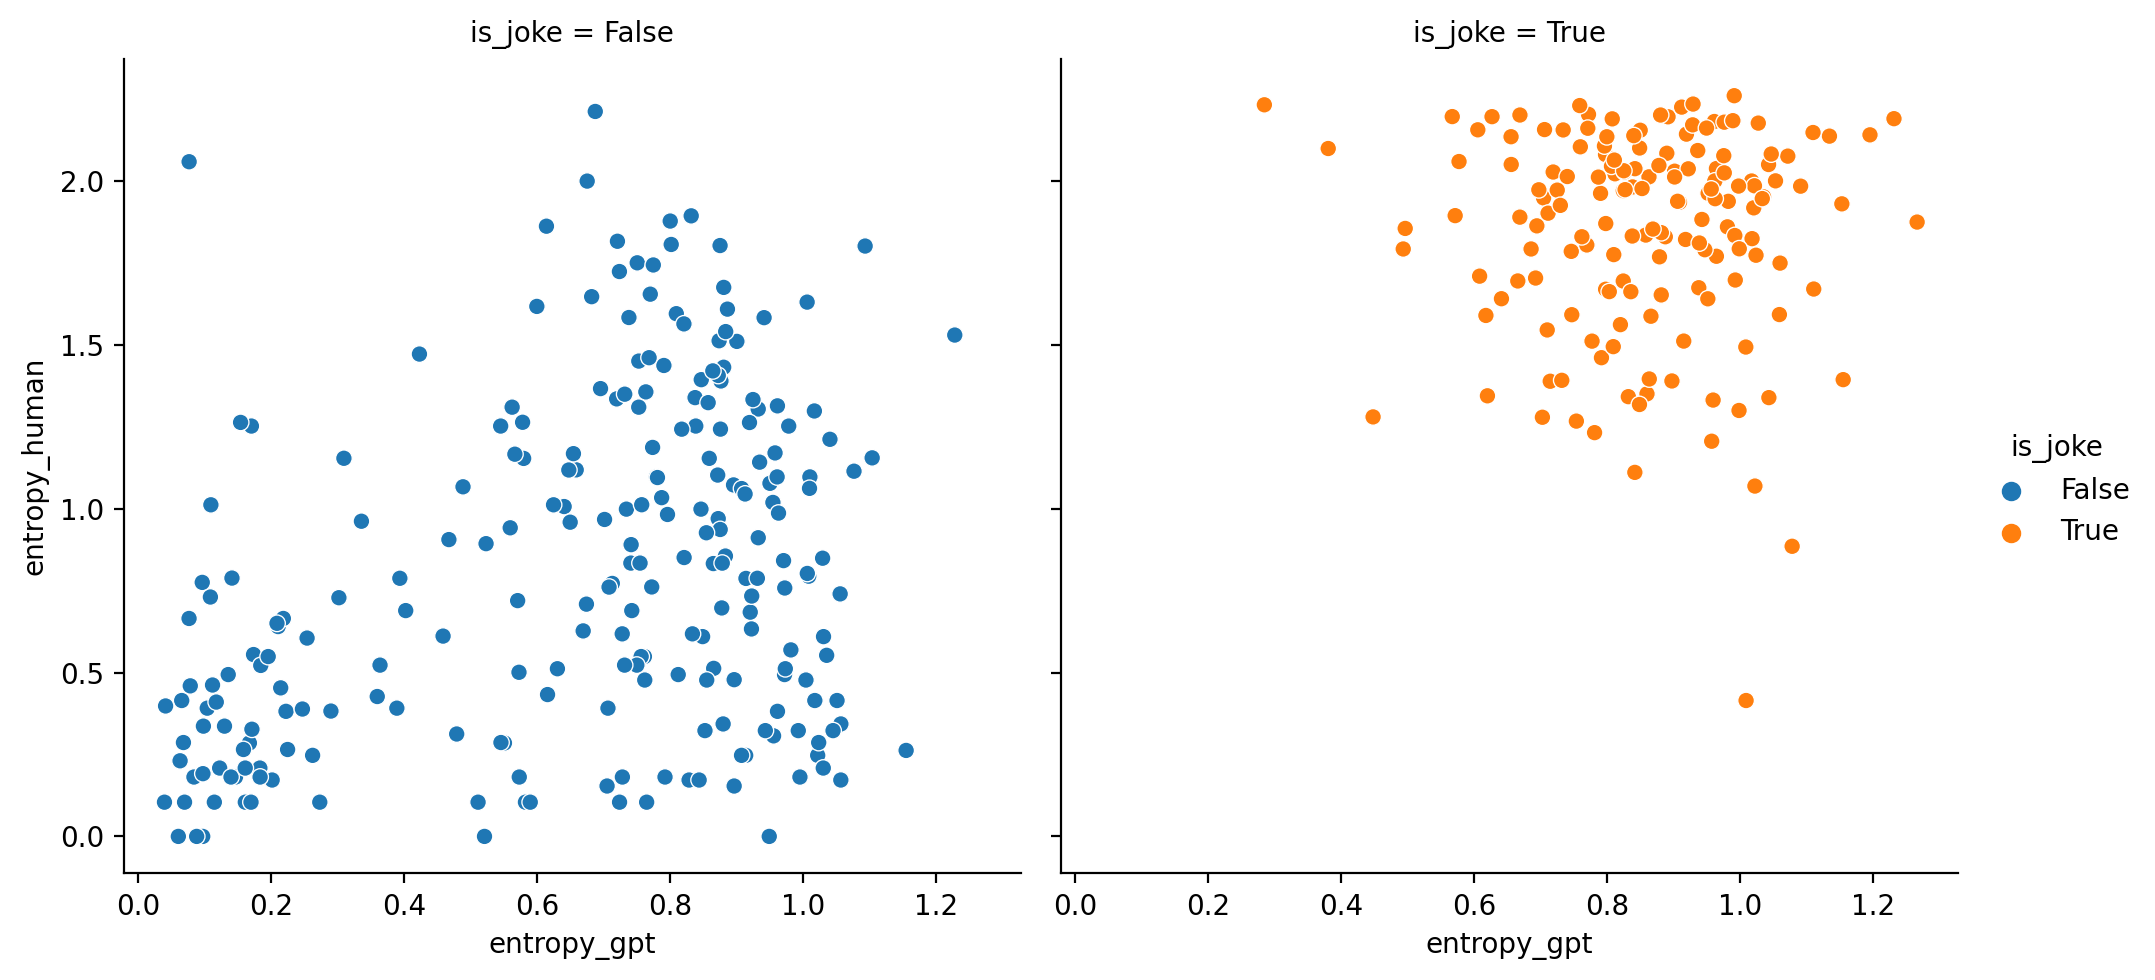

In [18]:
sns.relplot(data = df_merged, x = "entropy_gpt", y = "entropy_human", hue = "is_joke", col = "is_joke")

### Analysis 3: Entropy and comprehension

In [31]:
df_comprehension = pd.read_csv("data/processed/comprehension_probe_0shot.csv")
df_comprehension.shape

(400, 9)

In [32]:
def code_answer(row):
    if row['correct'] == "no":
        return row['lp_ratio'] < 0
    if row['correct'] == "yes":
        return row['lp_ratio'] > 0

df_comprehension['accurate'] = df_comprehension.apply(code_answer, axis = 1)
df_comprehension['Sentence'] = df_comprehension['sentence']
df_comprehension = df_comprehension[['Sentence', 'lp_ratio', 'accurate']]

In [33]:
df_merged = pd.merge(df_merged, df_comprehension)

<Axes: xlabel='accurate', ylabel='entropy_gpt'>

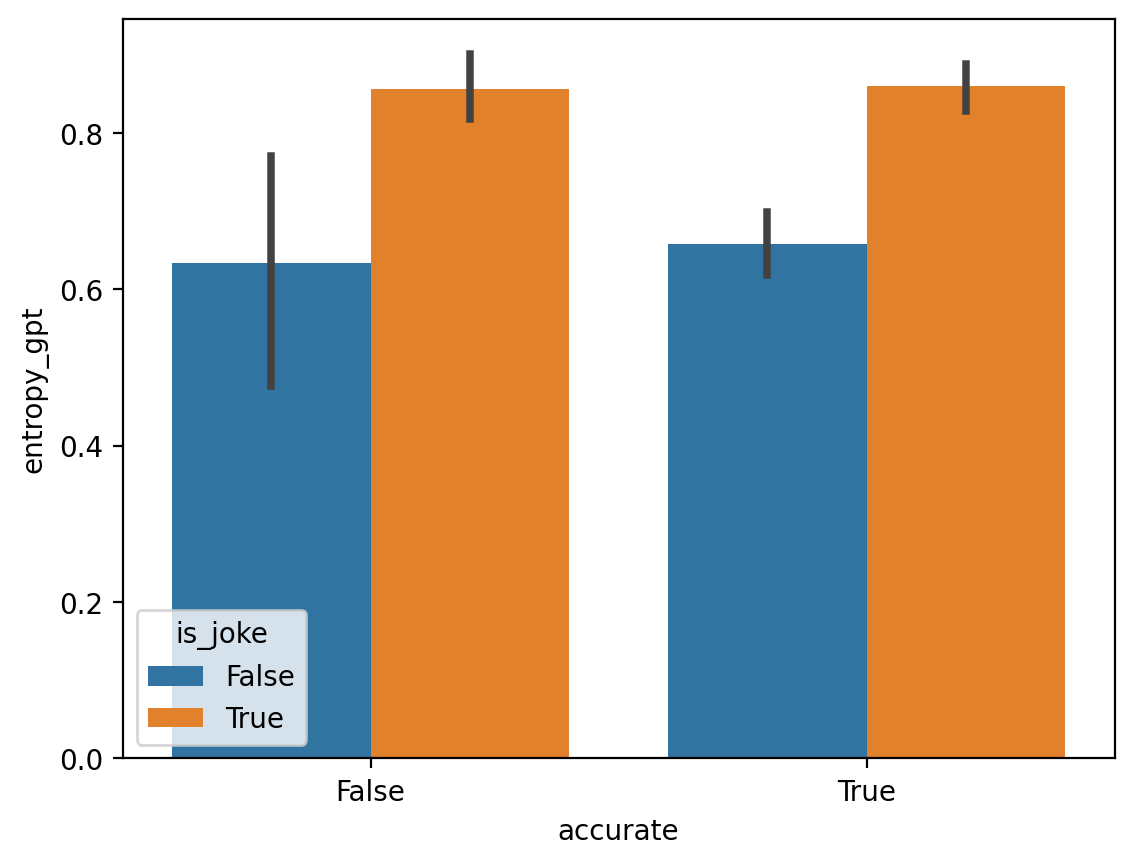

In [35]:
sns.barplot(data = df_merged, x = "accurate", y = "entropy_gpt", hue = "is_joke")

In [37]:
mod = sm.ols(data = df_merged, formula = "entropy_gpt ~ surprisal + is_joke + accurate").fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            entropy_gpt   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     26.83
Date:                Tue, 05 Dec 2023   Prob (F-statistic):           8.10e-16
Time:                        15:20:11   Log-Likelihood:                -25.808
No. Observations:                 400   AIC:                             59.62
Df Residuals:                     396   BIC:                             75.58
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.5700      0.043     13.369      0.000       0.486       0.654
is_joke[T.True]      0.1415      0.031      4.538      0.000       0.080       0.203
accurate[T.True]     0.0112      0.038      0.295      0.768      -0.063       0.085
surprisal            0.0148      0.003      4.681      0.000       0.009       0.021
==============================================================================
Omnibus:                       20.030   Durbin-Watson:                   1.743
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.728
Skew:                          -0.525   Prob(JB):                     3.15e-05
Kurtosis:                       2.624   Cond. No.                         35.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""